# Week 5 Miniproject - Monet Paintings

## Step 1: Brief description of problem


The objective of this project is to generat images in the style of Monet. For the project a GAN consisting of two neural networks will be implemented: a generator and a discriminator that will works against each other. One to create and one to distinguish images are fake or real. 

## Data. 
The dataset consist of four directories (two directories with two different images formats). One with fragments of the real Monet paintings and one with the general photos. The Monet dataset consist of 300 files, and Photo dataset has 7028 files.


In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

# Set up distribution strategy for efficient training
strategy = tf.distribute.get_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Path to the dataset in Google Cloud Storage
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_TFRECORD_FILES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_TFRECORD_FILES))

PHOTO_TFRECORD_FILES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_TFRECORD_FILES))

IMAGE_SIZE = [256, 256]
OUTPUT_CHANNELS = 3


ModuleNotFoundError: No module named 'tensorflow'

### Data Loading and processing


In [2]:
# Function to decode and preprocess the images
def decode_and_preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# Function to parse TFRecord files and preprocess images
def parse_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_and_preprocess_image(example['image'])
    return image

# Function to load dataset from TFRecord files
def load_tfrecord_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

# Load and batch the datasets
monet_dataset = load_tfrecord_dataset(MONET_TFRECORD_FILES).batch(1)
photo_dataset = load_tfrecord_dataset(PHOTO_TFRECORD_FILES).batch(1)

## Step 2: Exploratory Data Analysis (EDA)

### Visualize Sample Data:

In this section, we will load both datasets of images and perform an exploratory data analysis. We will display the data and identify characteristis. 

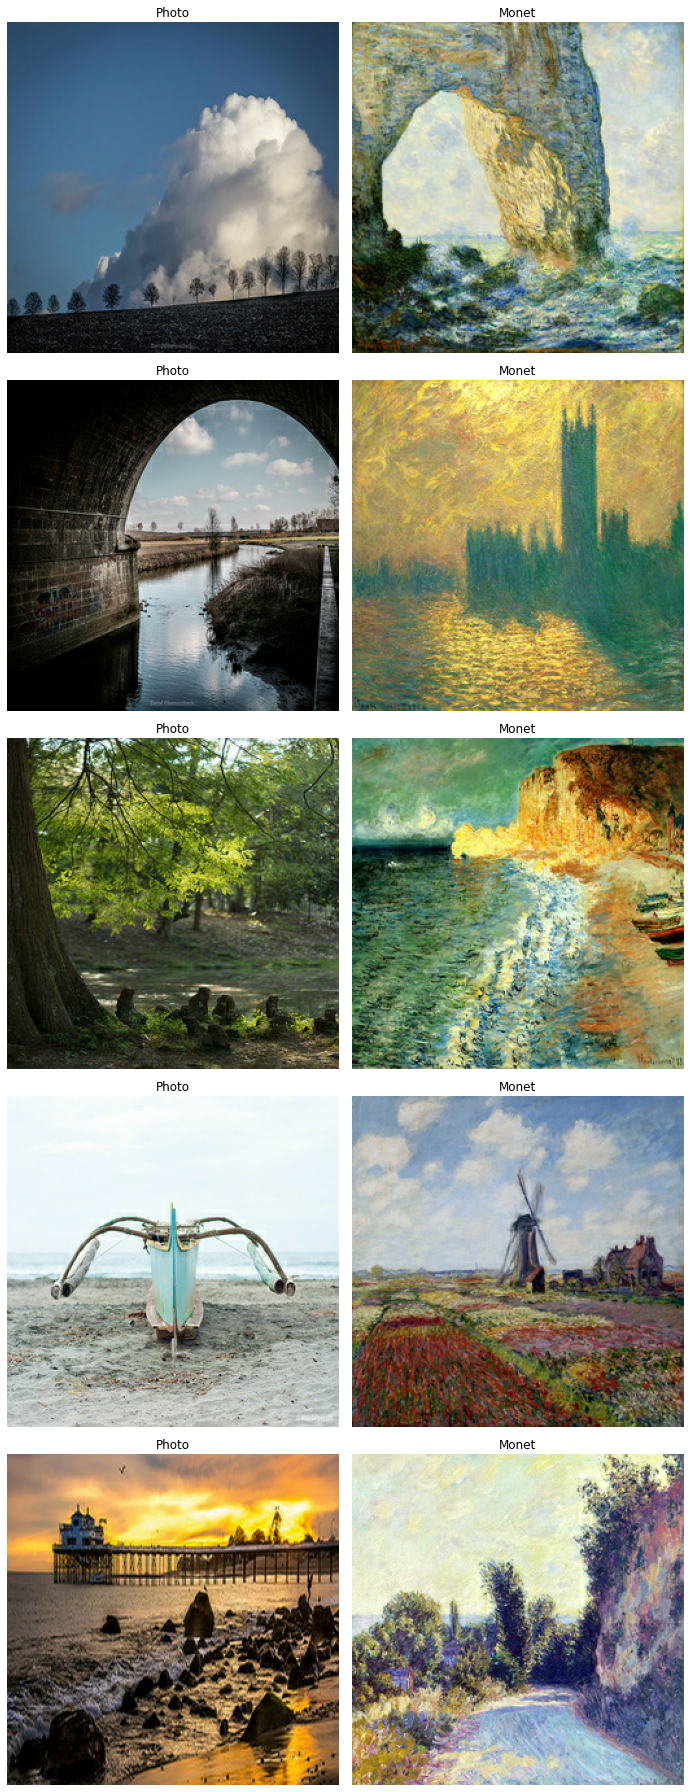

In [3]:
# Display a sample set of Monet paintings and a photos


# Number of samples to display
num_samples = 5

# Create a figure with 2 columns and num_samples rows
fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

# Iterate over the datasets and display images
for i, (monet_image, photo_image) in enumerate(zip(monet_dataset.take(num_samples), photo_dataset.take(num_samples))):
    # Display photo
    axes[i, 0].imshow(photo_image[0] * 0.5 + 0.5)
    axes[i, 0].set_title('Photo')
    axes[i, 0].axis('off')  # Hide axes
    
    # Display Monet painting
    axes[i, 1].imshow(monet_image[0] * 0.5 + 0.5)
    axes[i, 1].set_title('Monet')
    axes[i, 1].axis('off')  # Hide axes

# Adjust layout
plt.tight_layout()
plt.show()


## Step 3: Model Arquitecture

We will use Cycle GAN Arquitecture. The arquitecture can be better understood on this image: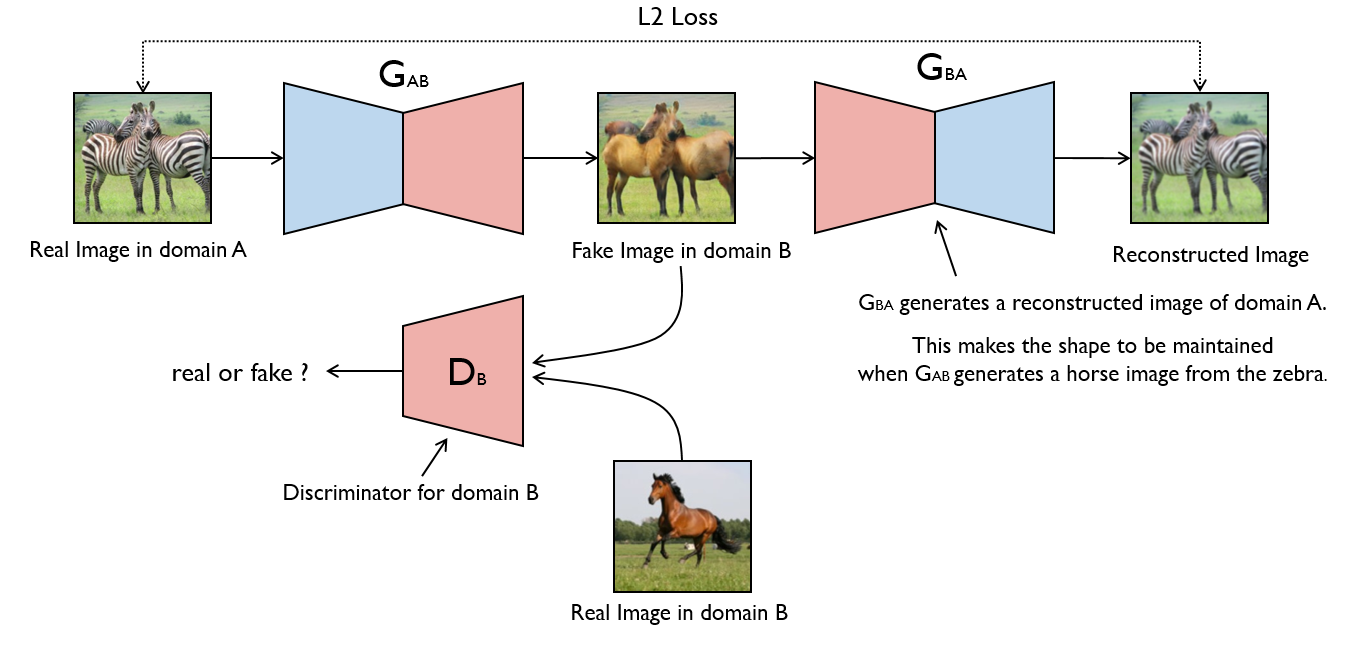

For this purpose we will need to create individual fucntions for each of the components:

1. Downsampling layers, to reduce dimensions  (blue elements on the picture)
2. Upsampling layers, to restore dimensions (blue elements on the picture)
3. Generators ( each of 7 Downampling + 7 Upsampling). Two will be requiered: the first one for Photo domain to Monet domain, and the second one for Monet domain to Photo domain. (G AB and G BA on the picture)
4. Discriminator  Db
5. The loss function to compare original images and reconstructed ( after G AB + G BA)
6. The general CycleGAN to put all elements together.

### Generator and Discriminator Models

### Define Downsampling layer

In [4]:
# Function to create a downsampling layer for the generator
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    layer.add(layers.LeakyReLU())

    return layer

### Define Upsampling Layer

In [5]:
# Function to create an upsampling layer for the generator
def create_upsample_layer(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        layer.add(layers.Dropout(0.5))

    layer.add(layers.ReLU())

    return layer

### Define the Generator G

In [6]:
# Function to create the generator model
def create_generator():
    inputs = layers.Input(shape=[256,256,3])

    # Downsampling layers
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (batch_size, 128, 128, 64)
        downsample(128, 4), # (batch_size, 64, 64, 128)
        downsample(256, 4), # (batch_size, 32, 32, 256)
        downsample(512, 4), # (batch_size, 16, 16, 512)
        downsample(512, 4), # (batch_size, 8, 8, 512)
        downsample(512, 4), # (batch_size, 4, 4, 512)
        downsample(512, 4), # (batch_size, 2, 2, 512)
        downsample(512, 4), # (batch_size, 1, 1, 512)
    ]

    # Upsampling layers
    up_stack = [
        create_upsample_layer(512, 4, apply_dropout=True), # (batch_size, 2, 2, 1024)
        create_upsample_layer(512, 4, apply_dropout=True), # (batch_size, 4, 4, 1024)
        create_upsample_layer(512, 4, apply_dropout=True), # (batch_size, 8, 8, 1024)
        create_upsample_layer(512, 4), # (batch_size, 16, 16, 1024)
        create_upsample_layer(256, 4), # (batch_size, 32, 32, 512)
        create_upsample_layer(128, 4), # (batch_size, 64, 64, 256)
        create_upsample_layer(64, 4), # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    output_layer = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skip_connections = []
    for down in down_stack:
        x = down(x)
        skip_connections.append(x)

    skip_connections = reversed(skip_connections[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skip_connections):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = output_layer(x)

    return keras.Model(inputs=inputs, outputs=x)

### Define the discriminator D

In [7]:
# Function to create the discriminator model
def create_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    input_image = layers.Input(shape=[256, 256, 3], name='input_image')

    x = input_image

    down1 = downsample(64, 4, False)(x) # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (batch_size, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)

    output_layer = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=input_image, outputs=output_layer)

with strategy.scope():
    monet_generator = create_generator() # transforms photos to Monet-esque paintings
    photo_generator = create_generator() # transforms Monet paintings to be more like photos

    monet_discriminator = create_discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = create_discriminator() # differentiates real photos and generated photos


### CycleGAN model definition

In [8]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


### Loss Functions L and Optimizers

In [9]:
# Define the loss functions and optimizers within the strategy scope

with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss


## Training the model

In [10]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

cycle_gan_model.fit(
   tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=25
)


Epoch 1/25
300/300 [==============================] - 129s 249ms/step - monet_gen_loss: 5.1667 - photo_gen_loss: 5.3479 - monet_disc_loss: 0.6613 - photo_disc_loss: 0.6372
Epoch 2/25
300/300 [==============================] - 76s 249ms/step - monet_gen_loss: 3.5823 - photo_gen_loss: 3.6898 - monet_disc_loss: 0.6650 - photo_disc_loss: 0.6369
Epoch 3/25
300/300 [==============================] - 76s 249ms/step - monet_gen_loss: 3.5139 - photo_gen_loss: 3.6440 - monet_disc_loss: 0.6588 - photo_disc_loss: 0.6173
Epoch 4/25
300/300 [==============================] - 75s 248ms/step - monet_gen_loss: 3.4058 - photo_gen_loss: 3.6300 - monet_disc_loss: 0.6470 - photo_disc_loss: 0.5824
Epoch 5/25
300/300 [==============================] - 75s 248ms/step - monet_gen_loss: 3.3458 - photo_gen_loss: 3.5091 - monet_disc_loss: 0.6292 - photo_disc_loss: 0.6000
Epoch 6/25
300/300 [==============================] - 76s 247ms/step - monet_gen_loss: 3.2639 - photo_gen_loss: 3.3560 - monet_disc_loss: 0.6187

## Step 4: Results and analysis

The training process for the CycleGAN model shows the progression of generator and discriminator losses over time. Here is a summary of the key observations:

Initial

monet_gen_loss: 10.7159 - photo_gen_loss: 10.5115
monet_disc_loss: 0.6930 - photo_disc_loss: 0.6931

Final

monet_gen_loss: 2.6554 - photo_gen_loss: 2.7396
monet_disc_loss: 0.6337 - photo_disc_loss: 0.6257

There is a significant reduction in generator losses, indicating that the generators have improved in producing more convincing images.

Regarding the discriminator, losses have decreased from 0.693 to 0.6337, suggesting that the discriminators are little better at distinguishing between real and fake images.
Analysis:

The initial high generator losses and near-random discriminator performance are typical in GAN training. As the training progresses, the generators get better at fooling the discriminators, and the discriminators get better at detecting fakes, leading to a decrease in both types of losses. The balance between generator and discriminator losses is crucial. If one improves too quickly, it can lead to instability in training. The steady reduction in both generator and discriminator losses indicates a relatively stable training process.


### Visualize and Save Generated Images

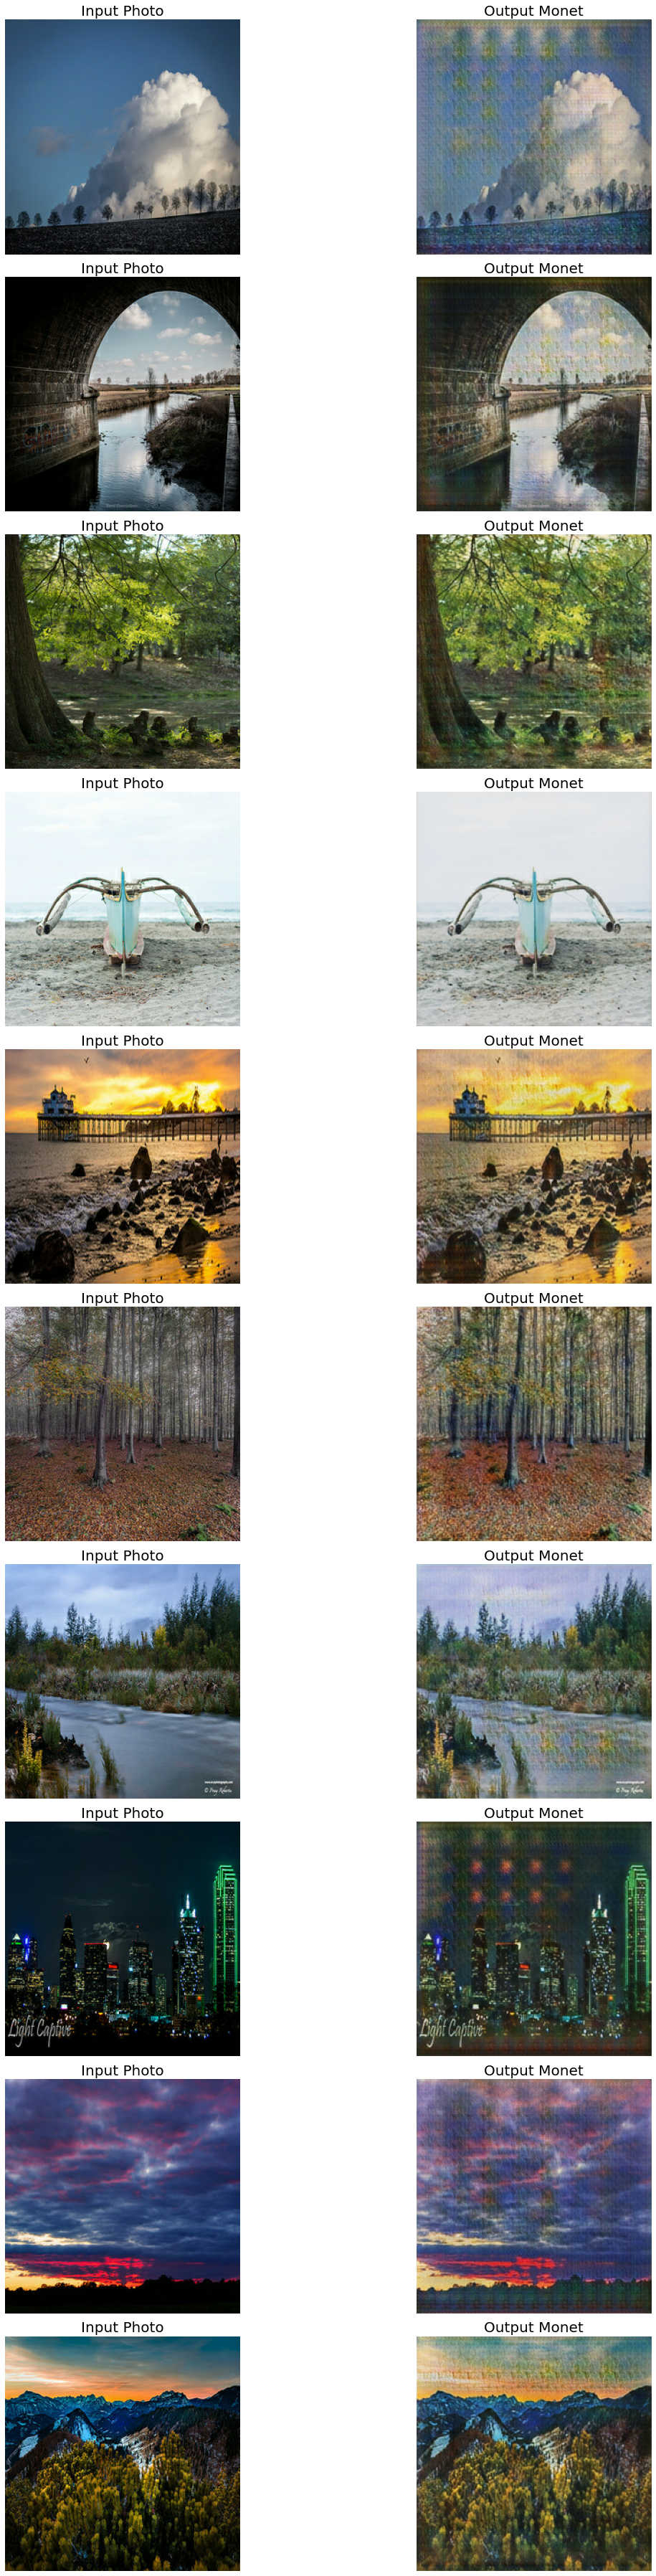

In [11]:

# Number of samples to display
num_samples = 10

# Create a figure with 10 rows and 2 columns to display pairs side by side
fig, axes = plt.subplots(num_samples, 2, figsize=(20, num_samples * 5))

# Iterate over the datasets and display images
for i, img in enumerate(photo_dataset.take(num_samples)):
    # Generate Monet-style image from input photo
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)  # Convert from [-1, 1] to [0, 255]
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)  # Convert from [-1, 1] to [0, 255]

    # Display the input photo
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Input Photo", fontsize=20)  # Increase the font size for better readability
    axes[i, 0].axis("off")  # Hide axes

    # Display the Monet-style output
    axes[i, 1].imshow(prediction)
    axes[i, 1].set_title("Output Monet", fontsize=20)  # Increase the font size for better readability
    axes[i, 1].axis("off")  # Hide axes

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Small horizontal and vertical gaps
plt.tight_layout()
plt.show()

## Step 5. Conclusions

rom the analysis of the final results, it is evident that there is still more work to be done. The photos can still be easily distinguished, although we can observe that some features of Monet's style have been captured.

We should evaluate to continue training for more epochs to see if the losses continue to decrease and if the image quality improves further.
Also experiment with different learning rates and other hyperparameters to potentially accelerate training and improve final performance.

In addition to quantitative losses, we can visually inspect the generated images to qualitatively assess the improvement in image quality, and use this as a feedback.


### Append 1.  Save generated images for submission

In [12]:
# Save the generated images
import PIL
! mkdir ../images

index = 1
for img in photo_dataset:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    image = PIL.Image.fromarray(prediction)
    image.save("../images/" + str(index) + ".jpg")
    index += 1

# Create a zip archive of the saved images
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'